In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 198 kB 51.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=8a5771a8e103578872ece14d07e512806425c87260ddba06301e39decb03ef2a
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import io

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler

!pip install transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
     |████████████████████████████████| 3.3 MB 29.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
import pyspark.sql.types
spark=SparkSession.builder.appName('Train').getOrCreate()
#spark2=SparkSession.builder.appName('Train2').getOrCreate()

In [ ]:
df_train = spark.read.format('csv').option('delimiter',';').load('gdrive/My Drive/BERT/train.txt')
df_train=df_train.withColumnRenamed("_c0","text")
df_train=df_train.withColumnRenamed("_c1","emotion")
#df_train.show()

In [ ]:
display(df_train)

DataFrame[text: string, emotion: string]

In [ ]:
df_val = spark.read.format('csv').option('delimiter',';').load('gdrive/My Drive/BERT/val.txt')
df_val=df_val.withColumnRenamed("_c0","text")
df_val=df_val.withColumnRenamed("_c1","emotion")
#df_val.show()

In [ ]:
df_test = spark.read.format('csv').option('delimiter',';').load('gdrive/My Drive/BERT/test.txt')
df_test=df_test.withColumnRenamed("_c0","text")
df_test=df_test.withColumnRenamed("_c1","emotion")
#df_val.show()

In [ ]:
df_train.groupBy("emotion").count().sort("count",ascending=True).show()
df_train.count()

+--------+-----+
| emotion|count|
+--------+-----+
|surprise|  572|
|    love| 1304|
|    fear| 1937|
|   anger| 2159|
| sadness| 4666|
|     joy| 5362|
+--------+-----+



16000

In [ ]:
ohe = OneHotEncoder(dropLast=False)
def ohe_encoder(df1):
  indexer = StringIndexer(inputCol="emotion", outputCol="emo_ohe2").fit(df1)
  df1 = indexer.transform(df1)
  ohe.setInputCols(["emo_ohe2"])
  ohe.setOutputCols(["emo_ohe"])
  model = ohe.fit(df1)
  df1 = model.transform(df1)
  #df1 = df1.drop('emotion')
  df1 = df1.drop('emo_ohe2')
  return df1

In [ ]:
df_train = ohe_encoder(df_train)
df_val = ohe_encoder(df_val)
df_test = ohe_encoder(df_test)

In [ ]:
emotions = ['surprise','love','fear','anger','sadness','joy']
emotion_count=[]

emomax = int(0)
for emo in emotions:
  for emoo in emotions:
    if df_train[df_train['emotion']==emoo].count() > df_train[df_train['emotion']==emo].count():
      emomax = df_train[df_train['emotion']==emoo].count()
  num_emo = df_train[df_train['emotion']==emo].count()
  emotion_count.append(emomax/num_emo)

In [ ]:
emotions_ratios = [int(np.round(x)) for x in emotion_count]

In [ ]:
index = 0
for emotion in emotions:
  df_emo = df_train.filter(col('emotion')==emotion)
  print(index,emotion)
  a = range(emotions_ratios[index]-1)
  df_emo_od = df_emo.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
  df_train = df_train.union(df_emo_od)
  index+=1

0 surprise
1 love
2 fear
3 anger
4 sadness
5 joy


In [ ]:
df_train.groupBy("emotion").count().sort("count",ascending=True).show()
df_train.count()

+--------+-----+
| emotion|count|
+--------+-----+
|   anger| 4318|
| sadness| 4666|
|surprise| 5148|
|    love| 5216|
|     joy| 5362|
|    fear| 5811|
+--------+-----+



30521

In [ ]:
df_train = df_train.drop('emotion')
df_val = df_val.drop('emotion')
df_test = df_test.drop('emotion')

In [ ]:
vectors = df_train.select("emo_ohe").rdd.map(lambda row: row.features)

from pyspark.mllib.linalg.distributed import RowMatrix

matrix = RowMatrix(vectors)


In [ ]:
print(matrix)

In [ ]:
train_data = df_train.toPandas()

val_data = df_val.toPandas()

test_data = df_test.toPandas()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30521 entries, 0 to 30520
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     30521 non-null  object
 1   emo_ohe  30521 non-null  object
dtypes: object(2)
memory usage: 477.0+ KB


In [ ]:
train_data.head()


,text,emo_ohe
0,i didnt feel humiliated,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,i can go from feeling so hopeless to so damned...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
2,im grabbing a minute to post i feel greedy wrong,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
3,i am ever feeling nostalgic about the fireplac...,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)"
4,i am feeling grouchy,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"


In [ ]:
test_data.head()

,text,emo_ohe
0,im feeling rather rotten so im not very ambiti...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,im updating my blog because i feel shitty,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
2,i never make her separate from me because i do...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
3,i left with my bouquet of red and yellow tulip...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,i was feeling a little vain when i did this one,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"


In [ ]:
val_data.head()

,text,emo_ohe
0,im feeling quite sad and sorry for myself but ...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
1,i feel like i am still looking at a blank canv...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
2,i feel like a faithful servant,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)"
3,i am just feeling cranky and blue,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
4,i can have for a treat or if i am feeling festive,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [ ]:
y_train=np.array(train_data['emo_ohe'])
y_test=np.array(test_data['emo_ohe'])
y_val=np.array(val_data['emo_ohe'])

In [ ]:
y_train

array([SparseVector(6, {1: 1.0}), SparseVector(6, {1: 1.0}),
       SparseVector(6, {2: 1.0}), ..., SparseVector(6, {2: 1.0}),
       SparseVector(6, {2: 1.0}), SparseVector(6, {2: 1.0})], dtype=object)

In [ ]:
def toarrayy(y_array):
  y_array2 = [x.toArray() for x in y_array]
  y_array = [x.astype(np.int64) for x in y_array2]
  return y_array


In [ ]:
y_train=toarrayy(y_train)
y_test=toarrayy(y_test)
y_val=toarrayy(y_val)

In [ ]:
type(y_train)

list

In [ ]:
y_train =np.array(y_train,dtype=np.float)
y_test=np.array(y_test,dtype=np.float)
y_val=np.array(y_val,dtype=np.float)

In [ ]:
y_train=np.asarray(y_train).astype(np.float)
y_test=np.asarray(y_test).astype(np.float)
y_val=np.asarray(y_val).astype(np.float)

In [ ]:
y_train
print(y_train)
print(type(y_train))

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
<class 'numpy.ndarray'>


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize(data,maximum_length) :
  input_ids = []
  attention_masks = []
  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus( 
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


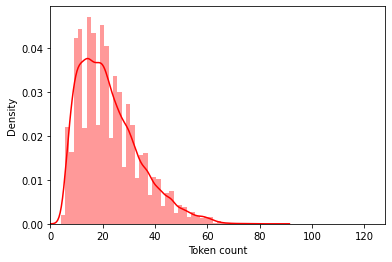

In [ ]:
token_lens = []
for txt in train_data.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens, color='red');
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
max_len=np.max(token_lens)
max_len

87

In [ ]:
max_len=88

In [ ]:
train_input_ids,train_attention_masks = tokenize(train_data, max_len)
test_input_ids,test_attention_masks = tokenize(test_data, max_len)
val_input_ids,val_attention_masks = tokenize(val_data, max_len)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    #output = tf.keras.layers.Dense(12, activation=tf.nn.relu)(output)
    #output = tf.keras.layers.Dropout(0.1)(output)
    output = tf.keras.layers.Dense(6, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model, max_len)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 88)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 88)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   TFBaseModelOutputWit 109482240   input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6)            4614        tf_bert_model_4[0][1]      

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=5,batch_size=60)

Epoch 1/5
509/509 [==============================] - 915s 2s/step - loss: 0.0781 - accuracy: 0.9709 - val_loss: 0.1686 - val_accuracy: 0.9380
Epoch 2/5
509/509 [==============================] - 917s 2s/step - loss: 0.0505 - accuracy: 0.9814 - val_loss: 0.2253 - val_accuracy: 0.9375
Epoch 3/5
509/509 [==============================] - 919s 2s/step - loss: 0.0389 - accuracy: 0.9864 - val_loss: 0.2489 - val_accuracy: 0.9330
Epoch 4/5
509/509 [==============================] - 924s 2s/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.2964 - val_accuracy: 0.9400
Epoch 5/5
509/509 [==============================] - 921s 2s/step - loss: 0.0250 - accuracy: 0.9926 - val_loss: 0.2912 - val_accuracy: 0.9320


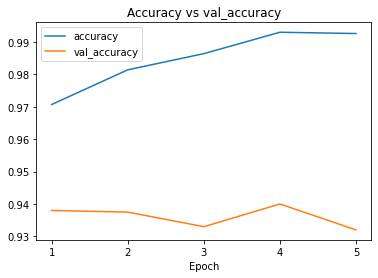

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

accuracy = [0.9707, 0.9814, 0.9864, 0.9930, 0.9926]
val_accuracy= [0.9380, 0.9375, 0.9330, 0.9400, 0.9320]

epoch=[1,2,3,4,5]
fig,ax = plt.subplots()
ax.plot(epoch, accuracy, label='accuracy')
ax.plot(epoch, val_accuracy, label='val_accuracy')
ax.set_title('Accuracy vs val_accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Epoch')
ax.set_ylabel('')
ax.legend()
plt.show()

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.931
F1 Score : 0.8965805964737297


In [ ]:
classification_report(y_test,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.97      0.93      0.95       695\n           1       0.96      0.98      0.97       581\n           2       0.95      0.91      0.93       275\n           3       0.92      0.88      0.90       224\n           4       0.75      0.92      0.83       159\n           5       0.75      0.86      0.80        66\n\n   micro avg       0.93      0.93      0.93      2000\n   macro avg       0.89      0.91      0.90      2000\nweighted avg       0.94      0.93      0.93      2000\n samples avg       0.93      0.93      0.93      2000\n'

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       695
           1       0.96      0.98      0.97       581
           2       0.95      0.91      0.93       275
           3       0.92      0.88      0.90       224
           4       0.75      0.92      0.83       159
           5       0.75      0.86      0.80        66

   micro avg       0.93      0.93      0.93      2000
   macro avg       0.89      0.91      0.90      2000
weighted avg       0.94      0.93      0.93      2000
 samples avg       0.93      0.93      0.93      2000



In [ ]:
y_pred_lab=np.argmax(y_pred, axis = 1)
y_test_lab=np.argmax(y_test, axis = 1)
conf_matrix=confusion_matrix(y_pred_lab,y_test_lab)

In [ ]:
conf_matrix=confusion_matrix(y_pred_lab,y_test_lab)
conf_matrix

array([[644,   3,   5,   0,  11,   3],
       [  1, 568,  11,   7,   0,   2],
       [  0,   4, 251,   7,   1,   0],
       [  0,   4,   8, 196,   0,   4],
       [ 47,   1,   0,   0, 146,   0],
       [  3,   1,   0,  14,   1,  57]])

In [ ]:
feels=['joy', 'sadness','anger','fear','love','surprise']

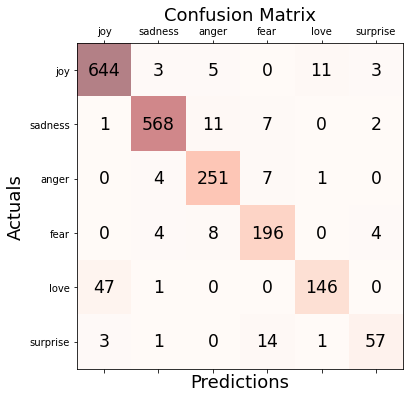

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels(['']+feels)
ax.set_yticklabels(['']+feels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()